In [ ]:
import os
from PIL import Image

def downsample_image(image, scale_factor):
    # Get the current width and height
    width, height = image.size

    # Calculate the new size by dividing by the scale factor
    new_size = (width // scale_factor, height // scale_factor)

    # Downsample using a lower-quality interpolation method
    # NEAREST interpolation will result in lower quality (pixelated)
    downsampled_image = image.resize(new_size, Image.BICUBIC)

    # Optional: Re-upsample back to the original size to further degrade quality
    low_quality_image = downsampled_image.resize((width, height), Image.BICUBIC)

    return low_quality_image


def prepare_data(hr_image_dir, lr_image_dir, scale_factor=2):
    if not os.path.exists(lr_image_dir):
        os.makedirs(lr_image_dir)
    hr_images = os.listdir(hr_image_dir)
    for img_name in hr_images:
        hr_image_path = os.path.join(hr_image_dir, img_name)
        lr_image_path = os.path.join(lr_image_dir, img_name)

        hr_image = Image.open(hr_image_path).convert('RGB')
        lr_image = downsample_image(hr_image, scale_factor)
        lr_image.save(lr_image_path)


In [ ]:
prepare_data('./high_res', 'low_res', scale_factor=2)

In [ ]:
import matplotlib.pyplot as plt

def display_images(lr_image, sr_image, hr_image=None):
    plt.figure(figsize=(15, 5))
    # Low-Resolution Image
    plt.subplot(1, 3, 1)
    plt.imshow(lr_image)
    plt.title('Low Resolution')
    plt.axis('off')
    # Super-Resolution Image
    plt.subplot(1, 3, 2)
    plt.imshow(sr_image)
    plt.title('Super Resolution')
    plt.axis('off')
    # High-Resolution Image
    if hr_image is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(hr_image)
        plt.title('High Resolution (Ground Truth)')
        plt.axis('off')
    plt.show()

In [ ]:
import torch
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.layer3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Instantiate the model
model = SRCNN()


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.lr_images = sorted([os.path.join(lr_dir, x) for x in os.listdir(lr_dir)])
        self.hr_images = sorted([os.path.join(hr_dir, x) for x in os.listdir(hr_dir)])
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image = Image.open(self.lr_images[idx]).convert('RGB')
        hr_image = Image.open(self.hr_images[idx]).convert('RGB')
        lr_image = self.to_tensor(lr_image)
        hr_image = self.to_tensor(hr_image)
        return lr_image, hr_image


In [ ]:
from torch.utils.data import random_split

batch_size = 16
train_dataset = SRDataset('./low_res', './high_res')

# Assuming `dataset` is your dataset (e.g., a list of image pairs)
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        """
        Args:
            patience (int): How many epochs to wait after the last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [ ]:
# Initialize the EarlyStopping object
early_stopping = EarlyStopping(patience=10, min_delta=0.0001)

# Training loop
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0

    # Training phase
    for lr_imgs, hr_imgs in train_loader:
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        optimizer.zero_grad()
        sr_imgs = model(lr_imgs)
        loss = criterion(sr_imgs, hr_imgs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:  # Use validation data loader
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            loss = criterion(sr_imgs, hr_imgs)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # Print losses for tracking
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping check
    early_stopping(avg_val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break


Epoch [1/100], Train Loss: 0.1193, Val Loss: 0.0204
Epoch [2/100], Train Loss: 0.0164, Val Loss: 0.0142
Epoch [3/100], Train Loss: 0.0131, Val Loss: 0.0118
Epoch [4/100], Train Loss: 0.0105, Val Loss: 0.0088
Epoch [5/100], Train Loss: 0.0078, Val Loss: 0.0066
Epoch [6/100], Train Loss: 0.0061, Val Loss: 0.0053
Epoch [7/100], Train Loss: 0.0050, Val Loss: 0.0044
Epoch [8/100], Train Loss: 0.0043, Val Loss: 0.0038
Epoch [9/100], Train Loss: 0.0038, Val Loss: 0.0034
Epoch [10/100], Train Loss: 0.0034, Val Loss: 0.0031
Epoch [11/100], Train Loss: 0.0032, Val Loss: 0.0029
Epoch [12/100], Train Loss: 0.0030, Val Loss: 0.0027
Epoch [13/100], Train Loss: 0.0028, Val Loss: 0.0025
Epoch [14/100], Train Loss: 0.0026, Val Loss: 0.0024
Epoch [15/100], Train Loss: 0.0024, Val Loss: 0.0022
Epoch [16/100], Train Loss: 0.0023, Val Loss: 0.0021
Epoch [17/100], Train Loss: 0.0022, Val Loss: 0.0020
Epoch [18/100], Train Loss: 0.0021, Val Loss: 0.0019
Epoch [19/100], Train Loss: 0.0020, Val Loss: 0.0019
Ep

In [ ]:
# After training is complete
torch.save(model, './super_res_model.pth')


In [ ]:
model = torch.load('./super_res_model.pth')

<ipython-input-21-98fd8005d57d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./super_res_model.pth')


In [32]:
from math import log10
import torch.nn.functional as F
import numpy as np
from skimage import metrics

def psnr(sr, hr):
    mse = F.mse_loss(sr, hr)
    if mse == 0:
        return float('inf')
    return 20 * log10(1.0 / torch.sqrt(mse))

# def evaluate_model(model, lr_image_path, hr_image_path):
#     model.eval()
#     lr_image = Image.open(lr_image_path).convert('RGB')
#     hr_image = Image.open(hr_image_path).convert('RGB')

#     to_tensor = ToTensor()
#     lr_image = to_tensor(lr_image).unsqueeze(0).to(device)
#     hr_image = to_tensor(hr_image).unsqueeze(0).to(device)

#     with torch.no_grad():
#         sr_image = model(lr_image)

#     psnr_value = psnr(sr_image, hr_image)
#     print(f"PSNR: {psnr_value:.2f} dB")

loss_values = []
psnr_values = []

def evaluate_images(model, lr_image_dir, hr_image_dir, num_images=15):

    lr_images = sorted(os.listdir(lr_image_dir))[:num_images]
    hr_images = sorted(os.listdir(hr_image_dir))[:num_images]

    for i, (lr_img_name, hr_img_name) in enumerate(zip(lr_images, hr_images)):
        lr_image_path = os.path.join(lr_image_dir, lr_img_name)
        hr_image_path = os.path.join(hr_image_dir, hr_img_name)
        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')

        # Convert to tensor and run through model
        lr_tensor = ToTensor()(lr_image).unsqueeze(0).to(device)
        with torch.no_grad():
            sr_tensor = model(lr_tensor)
        sr_image = sr_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
        sr_image = np.clip(sr_image, 0, 1)  # Ensure valid image values

        # Calculate PSNR
        hr_tensor = ToTensor()(hr_image).unsqueeze(0).to(device)
        psnr_value = psnr(sr_tensor, hr_tensor)
        psnr_values.append(psnr_value)

        # Example: Assuming loss calculation can be done here
        loss = criterion(sr_tensor, hr_tensor)  # Uncomment if criterion is defined
        loss_values.append(loss.item())  # Collect loss values

        # Display images
        display_images(lr_image, sr_image, hr_image)


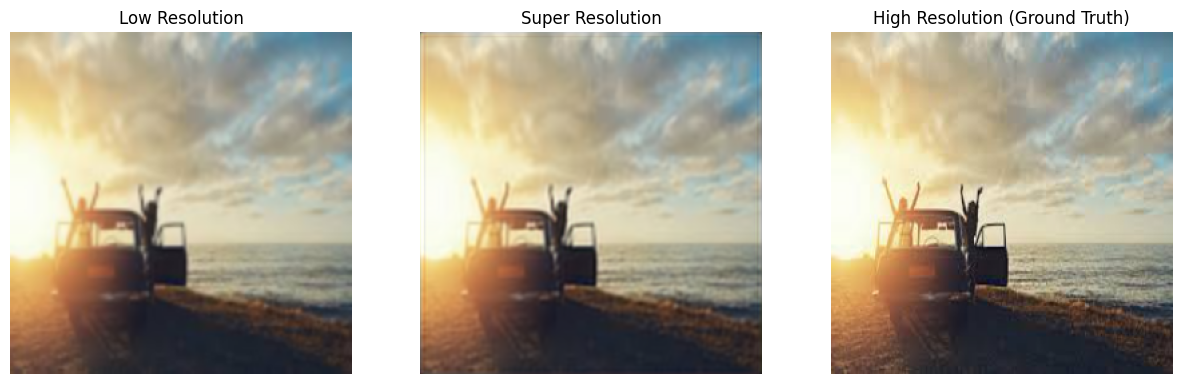

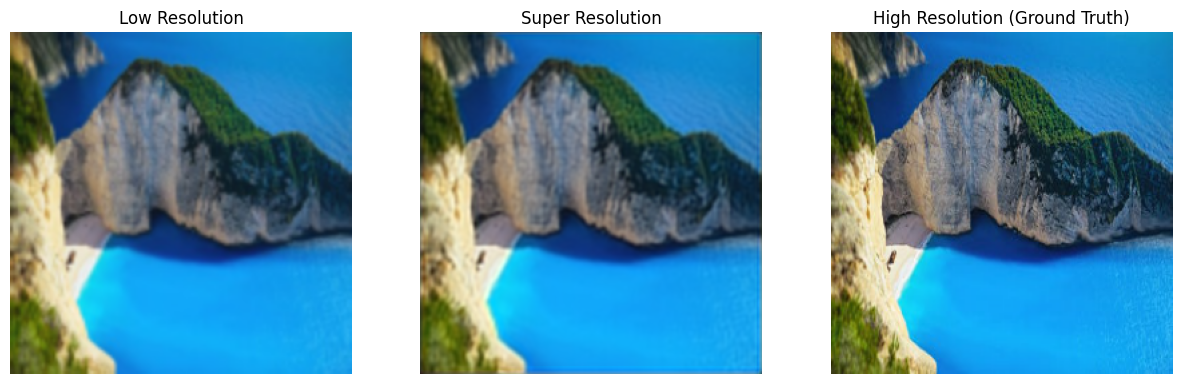

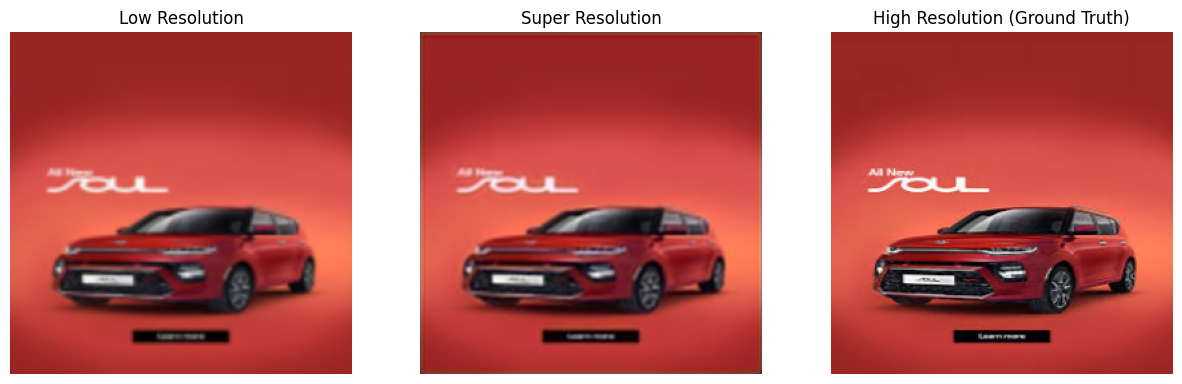

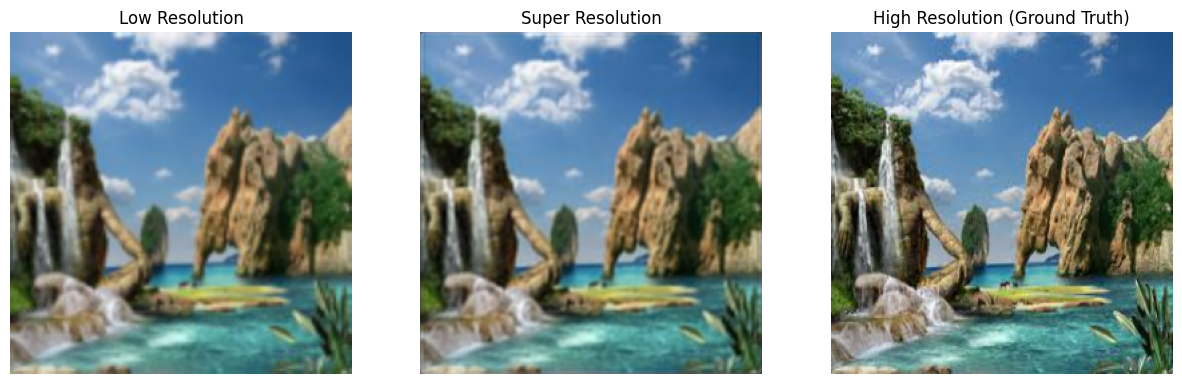

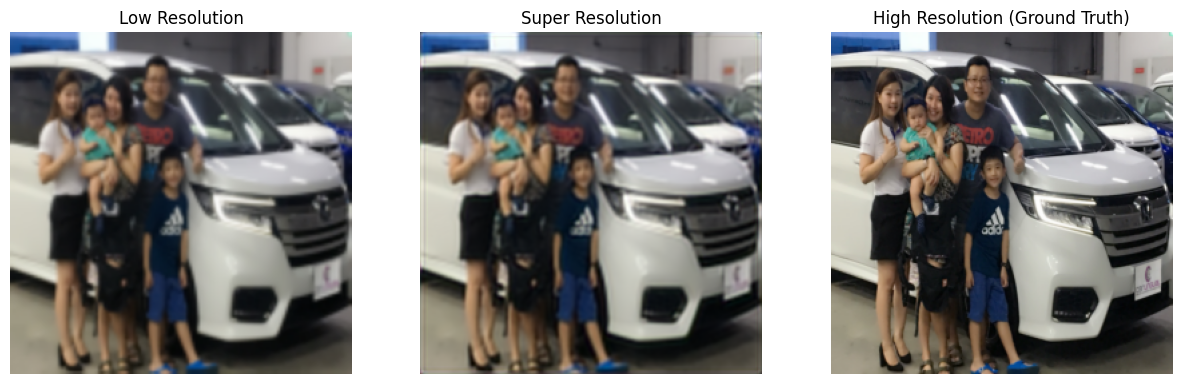

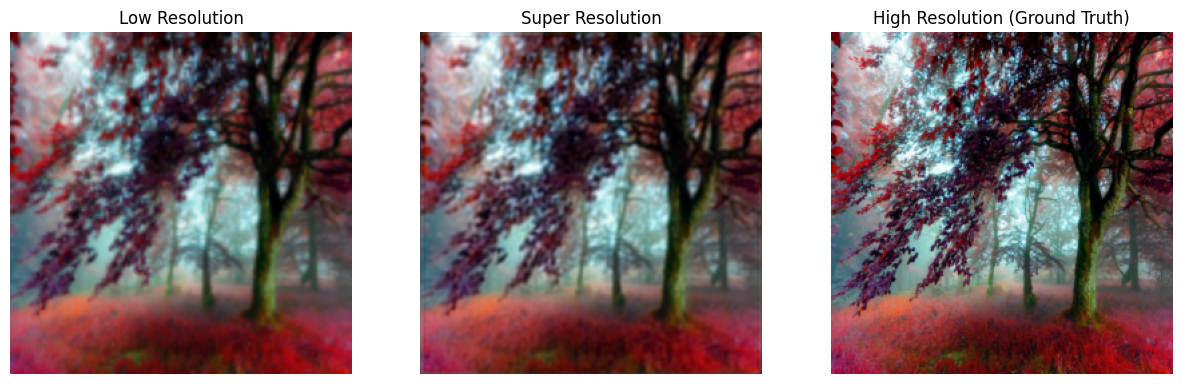

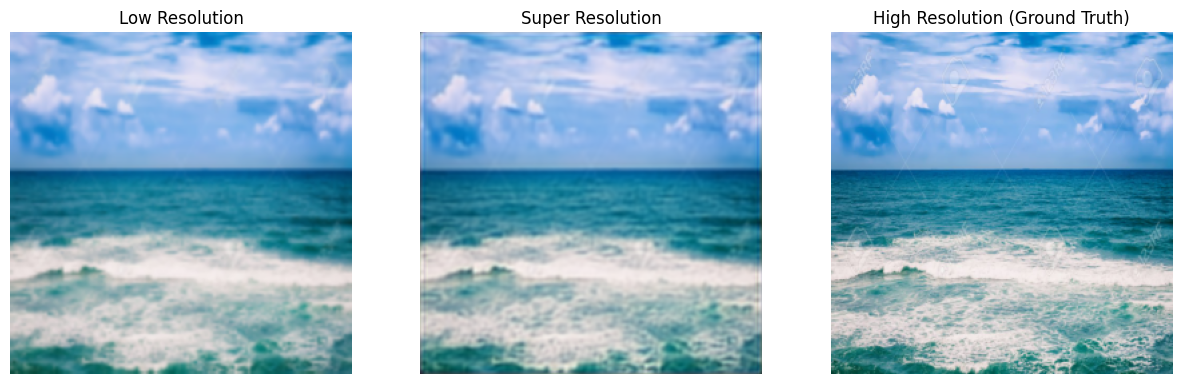

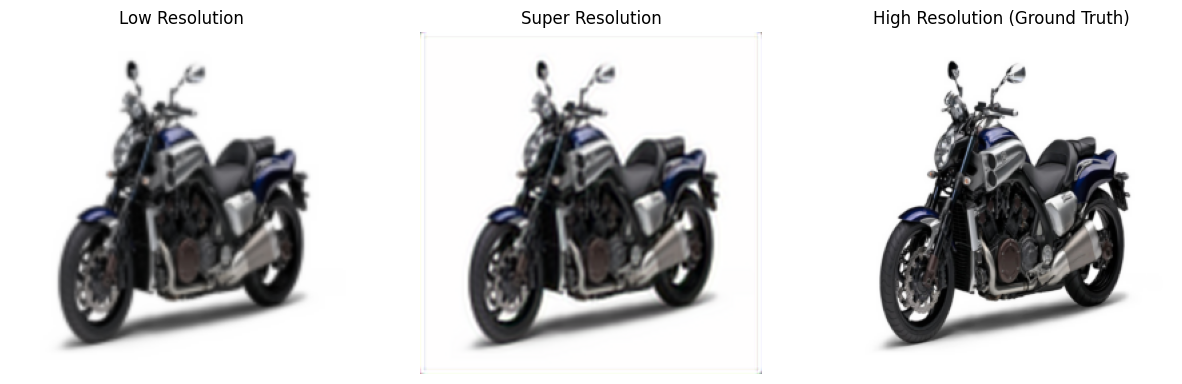

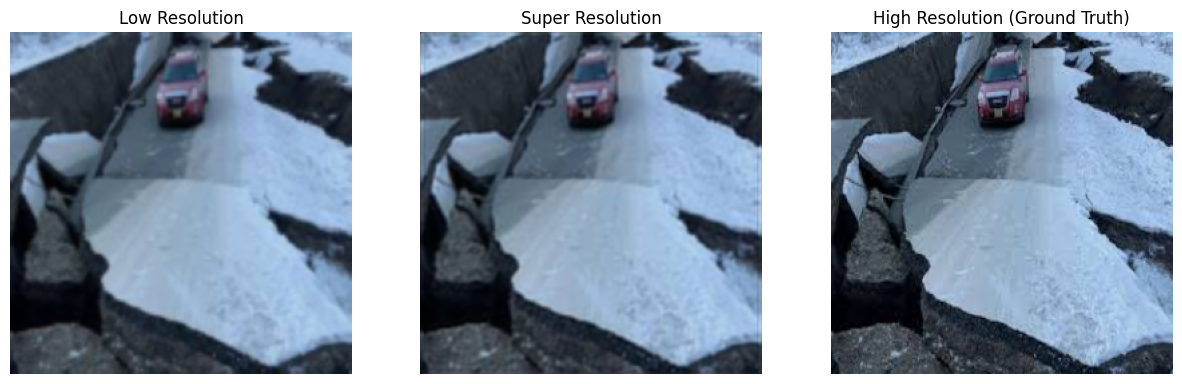

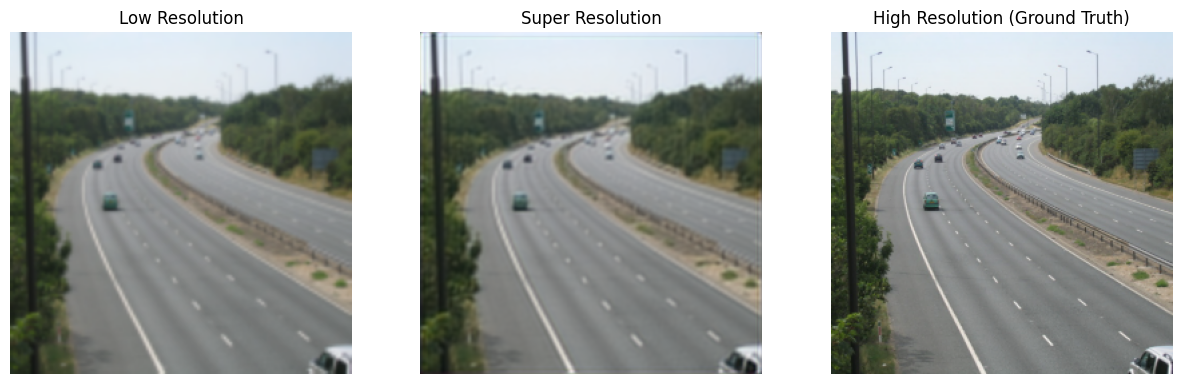

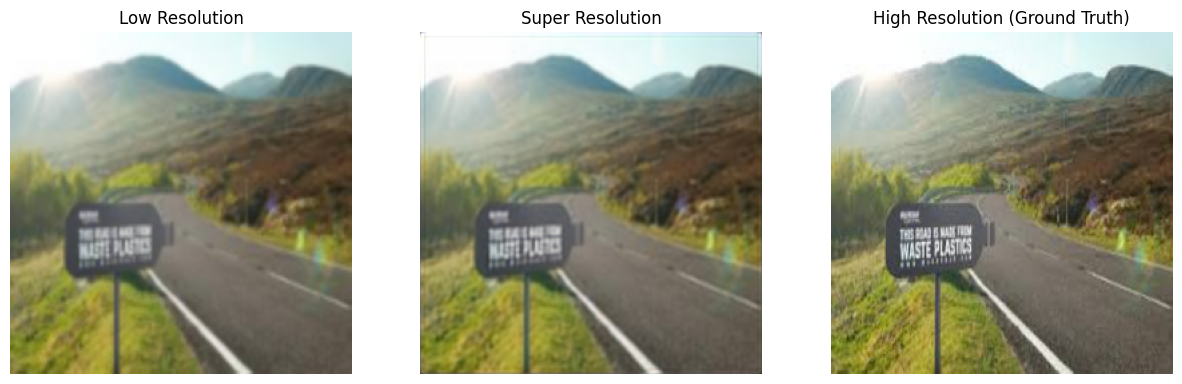

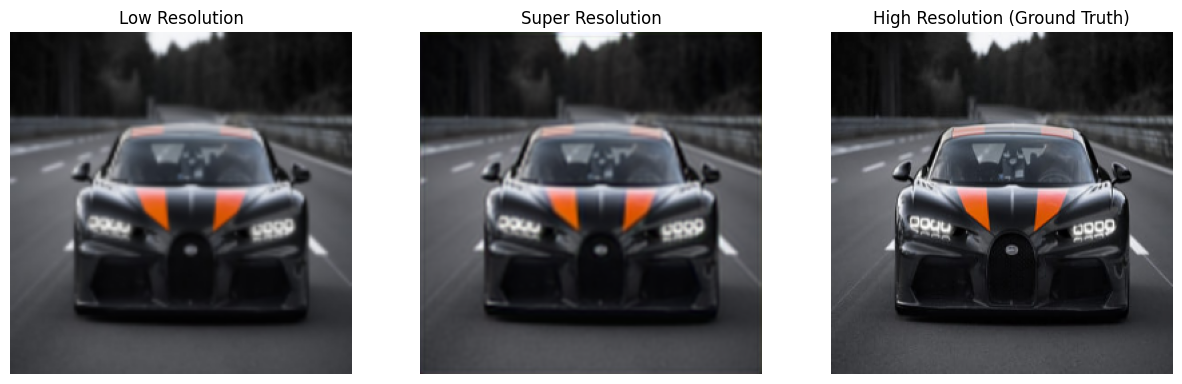

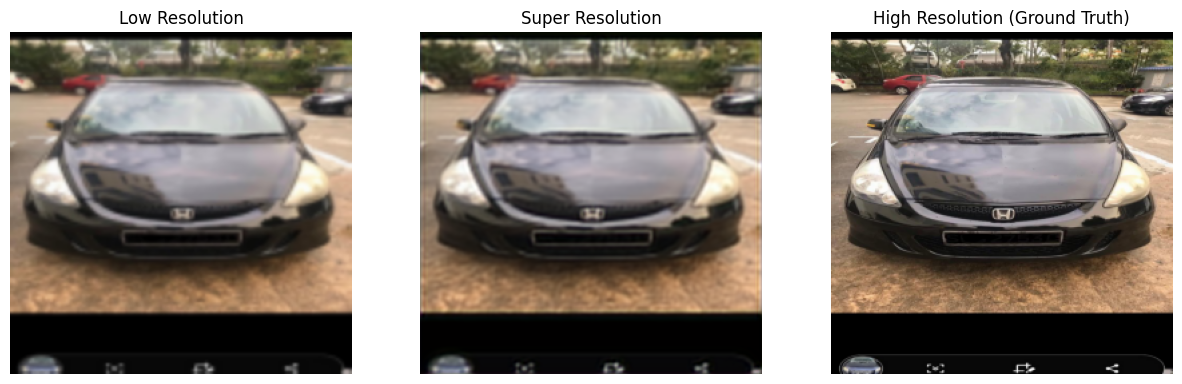

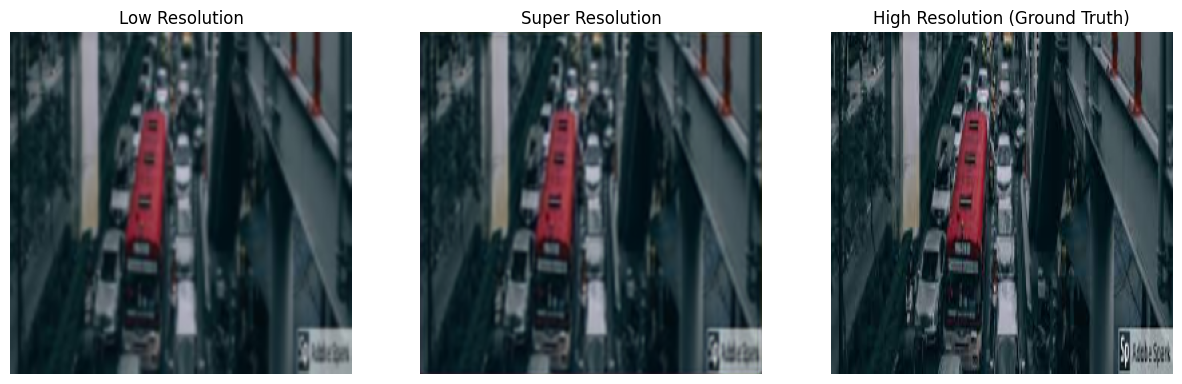

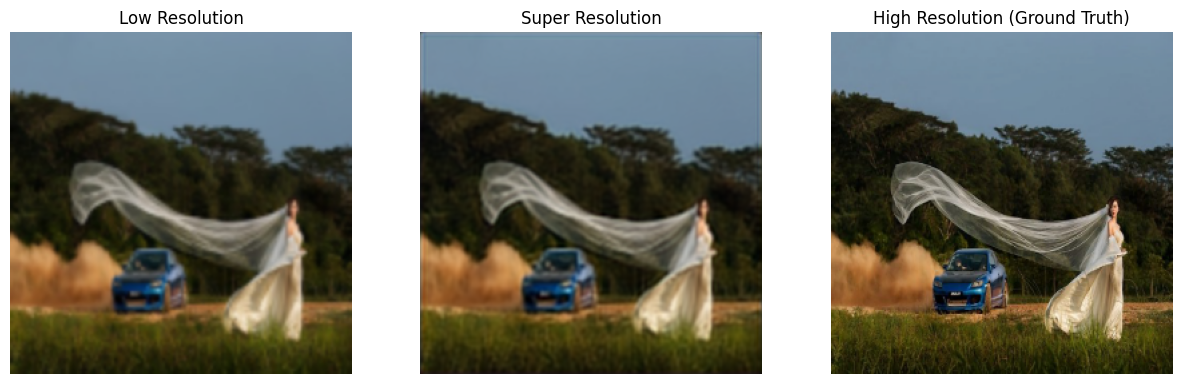

In [33]:
evaluate_images(model, './test_low_res', './test_high_res')

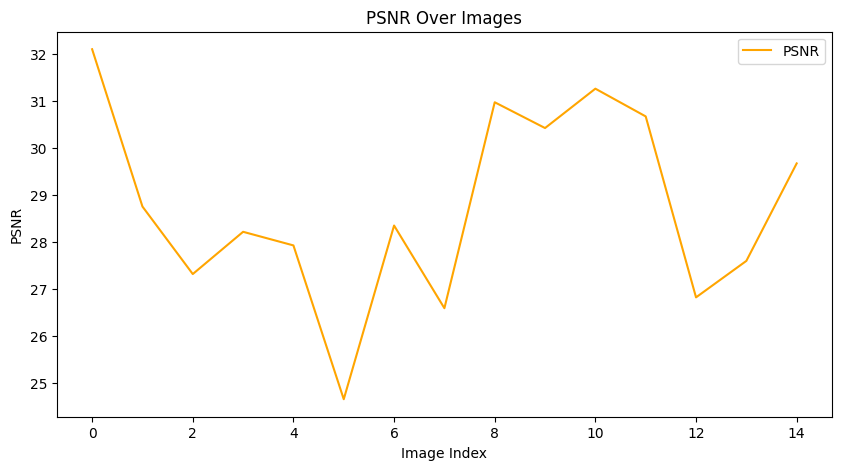

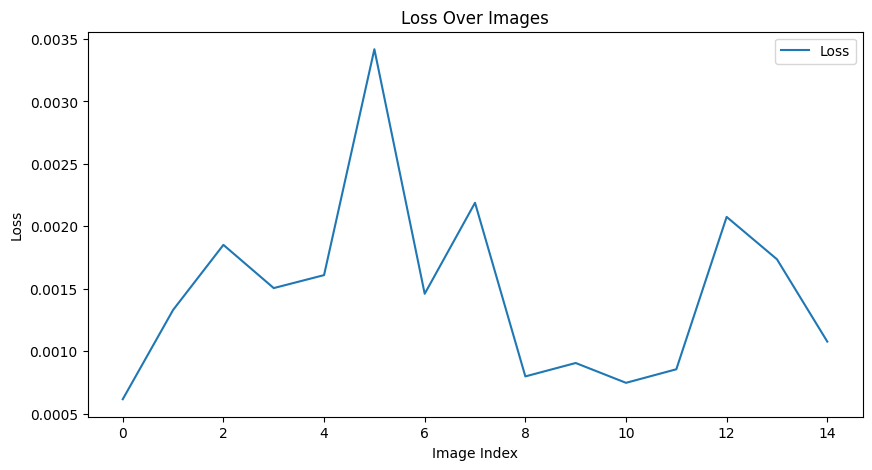

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(psnr_values, label='PSNR', color='orange')
plt.title('PSNR Over Images')
plt.xlabel('Image Index')
plt.ylabel('PSNR')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss')
plt.title('Loss Over Images')
plt.xlabel('Image Index')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from torchvision import transforms

def super_resolve_image(model, lr_image_path, output_path):
    model.eval()
    lr_image = Image.open(lr_image_path).convert('RGB')
    to_tensor = ToTensor()
    lr_image_tensor = to_tensor(lr_image).unsqueeze(0).to(device)

    with torch.no_grad():
        sr_image_tensor = model(lr_image_tensor)

    sr_image = sr_image_tensor.squeeze(0).cpu()
    sr_image = torch.clamp(sr_image, 0.0, 1.0)
    to_pil = transforms.ToPILImage()
    sr_image = to_pil(sr_image)
    sr_image.save(output_path)


In [ ]:
super_resolve_image(model, './test_data/test.jpg', './test_sr.jpg')
